# EDA - Isolation Forest

In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import util
import json
from sklearn.ensemble import IsolationForest

matplotlib.interactive('True')
STATE = 42

# Metric conversion from exported CloudWatch JSON to pandas DataFrames
metrics = util.json_to_pandas('../ExportedMetrics/ServiceA/LambdaA.json')
for metric in metrics:
    print(f'{metric.upper()}:\n',metrics[metric], '\n\n')

DURATION:
                      Timestamps      Values
0     2020-10-17 11:40:00+00:00  378.087143
1     2020-10-17 11:45:00+00:00  337.360294
2     2020-10-17 11:50:00+00:00  350.329167
3     2020-10-17 11:55:00+00:00  380.851136
4     2020-10-17 12:00:00+00:00  358.283182
...                         ...         ...
17931 2020-12-19 10:07:00+00:00  435.340213
17932 2020-12-19 10:12:00+00:00  386.125432
17933 2020-12-19 10:17:00+00:00  436.342903
17934 2020-12-19 10:22:00+00:00  464.948276
17935 2020-12-19 10:27:00+00:00  429.102174

[17936 rows x 2 columns] 


CONCURRENTEXECUTIONS:
                      Timestamps    Values
0     2020-10-17 11:40:00+00:00  2.047619
1     2020-10-17 11:45:00+00:00  1.617647
2     2020-10-17 11:50:00+00:00  1.250000
3     2020-10-17 11:55:00+00:00  1.613636
4     2020-10-17 12:00:00+00:00  1.954545
...                         ...       ...
17931 2020-12-19 10:07:00+00:00  1.425532
17932 2020-12-19 10:12:00+00:00  1.234568
17933 2020-12-19 10:17:00+00:00

### Importing microservice release dates

In [8]:
releases = util.load_releases('../ExportedMetrics/releases.json')
releases.head(10)

,ServiceNames,Timestamps
0,ServiceA,2020-10-15 13:09:02.003799915+00:00
1,ServiceHIK,2020-10-15 14:18:49.004899979+00:00
2,ServiceB,2020-10-15 14:21:56.005199909+00:00
3,ServiceB,2020-10-19 08:30:09.000400066+00:00
4,ServiceHIK,2020-10-21 13:49:47.005199909+00:00
5,ServiceB,2020-10-22 12:20:14.000600100+00:00
6,ServiceCD,2020-10-23 14:04:43.000400066+00:00
7,ServiceB,2020-10-28 09:16:09.000900030+00:00
8,ServiceB,2020-10-28 11:33:24.003599882+00:00
9,ServiceA,2020-10-29 09:56:09.004199982+00:00


In [78]:
releasesA = releases.loc[releases['ServiceNames'] == 'ServiceA']

In [9]:
df = metrics['Duration']
# df_test = df[5000:8000]
df_test = df.copy()

### Adding feature `PostRelease` for rows right after a microservice deployment

In [84]:
df_test = util.calculate_postrelease_feature(df_test, releasesA)
df_test.PostRelease.value_counts()

Earliest in-scope release date:  2020-10-17 11:50:00+00:00
Latest in-scope release date:  2020-12-19 10:27:00+00:00
Dropped 1 out of scope release date(s)


0    17902
1       15
Name: PostRelease, dtype: int64

In [87]:
df_test.loc[df_test['PostRelease'] == 1]

,Timestamps,Values,PostRelease
3435,2020-10-29 10:00:00+00:00,63.816667,1
4924,2020-11-03 14:05:00+00:00,81.053333,1
5747,2020-11-06 10:40:00+00:00,50.236667,1
6669,2020-11-09 15:30:00+00:00,48.696000,1
7178,2020-11-11 09:55:00+00:00,62.959231,1
7815,2020-11-13 15:00:00+00:00,47.820000,1
8899,2020-11-17 09:20:00+00:00,58.356667,1
10628,2020-11-23 10:25:00+00:00,88.970000,1
12739,2020-12-01 11:05:00+00:00,85.213333,1
13087,2020-12-02 16:05:00+00:00,90.170000,1


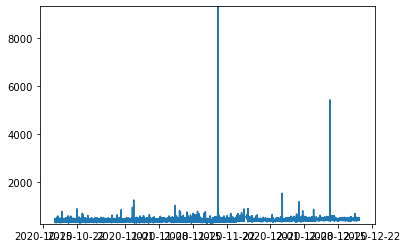

In [12]:
plt.plot(df_test.Timestamps, df_test.Values)
axes = plt.axes()
axes.set_ylim([df_test.Values.min(), df_test.Values.max()])
plt.show()
del axes

### STL Decomposition

* Note: The trend around the start and end of the time series is extrapolated, otherwise it would be missing.

In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17936 entries, 0 to 17935
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   Timestamps               17936 non-null  datetime64[ns, UTC]
 1   Values                   17936 non-null  float64            
 2   Trend_Values             17936 non-null  float64            
 3   Seasonal_Values          17936 non-null  float64            
 4   Residual_Values          17936 non-null  float64            
 5   Values_Scores            17936 non-null  float64            
 6   Values_Inliers           17936 non-null  int32              
 7   Residual_Values_Scores   17936 non-null  float64            
 8   Residual_Values_Inliers  17936 non-null  int32              
dtypes: datetime64[ns, UTC](1), float64(6), int32(2)
memory usage: 1.1 MB


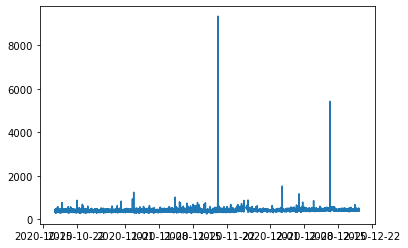

In [35]:
plt.plot(df_test.Timestamps, df_test.Values)

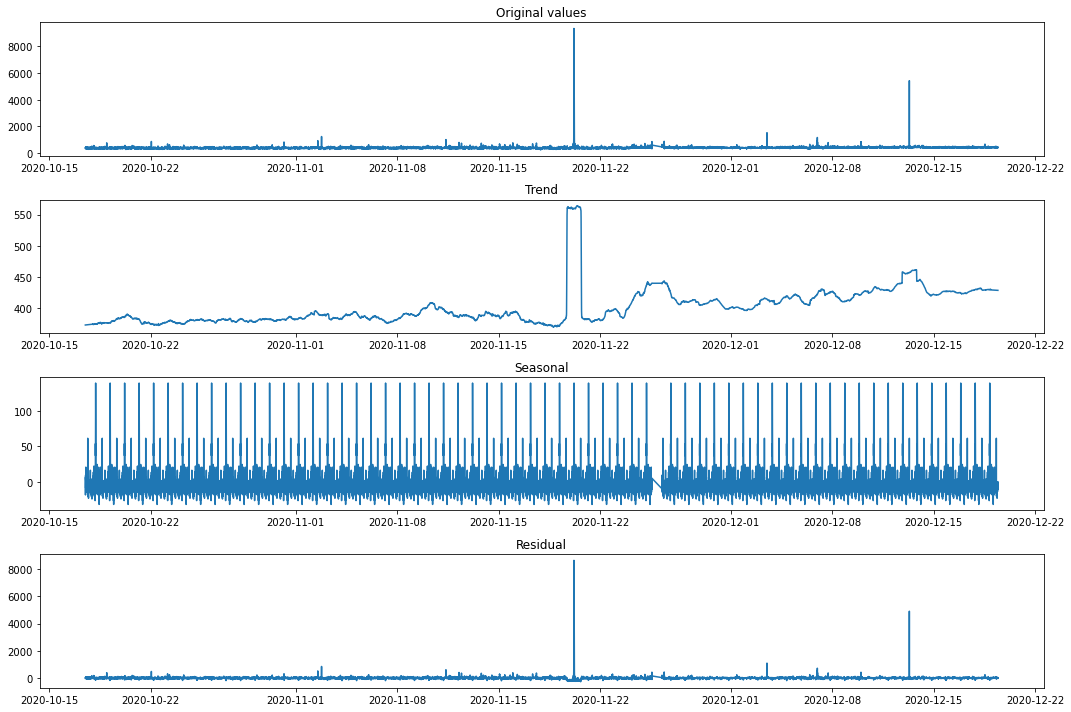

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_result = seasonal_decompose(df_test.Values, period=288, extrapolate_trend='freq')

fig, axs = plt.subplots(4,1, figsize=(15,10), sharex=False)
axs[0].plot(df_test.Timestamps, df_test.Values)
axs[0].set_title('Original values')
axs[1].plot(df_test.Timestamps, decompose_result.trend)
axs[1].set_title('Trend')
axs[2].plot(df_test.Timestamps, decompose_result.seasonal)
axs[2].set_title('Seasonal')
axs[3].plot(df_test.Timestampsdecompose_result.resid)
axs[3].set_title('Residual')
plt.tight_layout()
plt.show()

In [40]:
df_test['Trend_Values'] = decompose_result.trend
df_test['Seasonal_Values'] = decompose_result.seasonal
df_test['Residual_Values'] = decompose_result.resid
df_test.head()

,Timestamps,Values,Trend_Values,Seasonal_Values,Residual_Values,Values_Scores,Values_Inliers,Residual_Values_Scores,Residual_Values_Inliers
0,2020-10-17 11:40:00+00:00,378.087143,372.815942,6.575127,-1.303927,0.294695,1,0.320151,1
1,2020-10-17 11:45:00+00:00,337.360294,372.825041,4.920354,-40.385101,0.207444,1,0.301625,1
2,2020-10-17 11:50:00+00:00,350.329167,372.834139,1.728216,-24.233188,0.265254,1,0.330056,1
3,2020-10-17 11:55:00+00:00,380.851136,372.843237,-17.885294,25.893194,0.295216,1,0.303133,1
4,2020-10-17 12:00:00+00:00,358.283182,372.852335,4.817719,-19.386872,0.287783,1,0.340495,1


### Model fitting for original values and decomposed residual values

In [41]:
model = IsolationForest(
    max_features = 1.0,
    n_estimators = 50,
    max_samples = 'auto',
    contamination = 0.01,
    random_state = STATE
)
model.fit(df_test[['Values']])
df_test['Values_Scores'] = model.decision_function(df_test[['Values']])
df_test['Values_Inliers'] = model.predict(df_test[['Values']])

model.fit(df_test[['Residual_Values']])
df_test['Residual_Values_Scores'] = model.decision_function(df_test[['Residual_Values']])
df_test['Residual_Values_Inliers'] = model.predict(df_test[['Residual_Values']])

print(df_test.head())

                 Timestamps      Values  Trend_Values  Seasonal_Values  \
0 2020-10-17 11:40:00+00:00  378.087143    372.815942         6.575127   
1 2020-10-17 11:45:00+00:00  337.360294    372.825041         4.920354   
2 2020-10-17 11:50:00+00:00  350.329167    372.834139         1.728216   
3 2020-10-17 11:55:00+00:00  380.851136    372.843237       -17.885294   
4 2020-10-17 12:00:00+00:00  358.283182    372.852335         4.817719   

   Residual_Values  Values_Scores  Values_Inliers  Residual_Values_Scores  \
0        -1.303927       0.294695               1                0.320151   
1       -40.385101       0.207444               1                0.301625   
2       -24.233188       0.265254               1                0.330056   
3        25.893194       0.295216               1                0.303133   
4       -19.386872       0.287783               1                0.340495   

   Residual_Values_Inliers  
0                        1  
1                        1  
2    

In [42]:
# print(df_test.Values_Inliers.value_counts()[1])
values_anomaly_counts = df_test.Values_Inliers.value_counts()[-1]
residual_values_anomaly_counts = df_test.Residual_Values_Inliers.value_counts()[-1]
print(f'Anomalous data points from raw values: {values_anomaly_counts} / {len(df_test["Values_Inliers"])}')
print(f'Anomalous data points from decomposed residual values: {residual_values_anomaly_counts} / {len(df_test["Residual_Values_Inliers"])}')

Anomalous data points from raw values: 176 / 17936
Anomalous data points from decomposed residual values: 170 / 17936


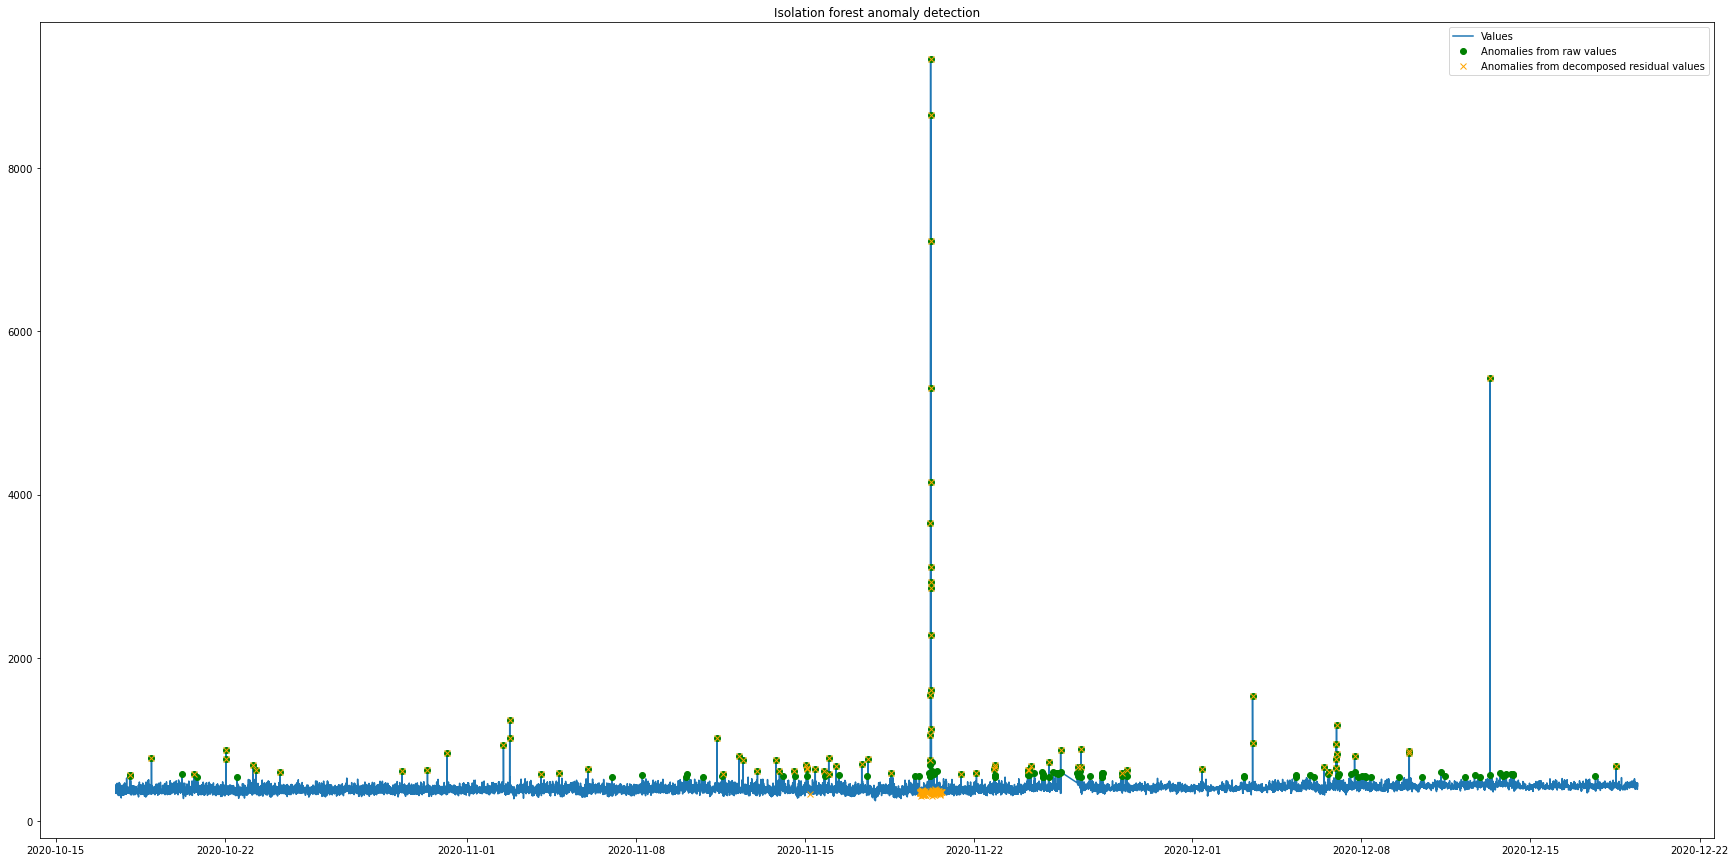

In [59]:
values_anomalies = df_test.loc[df_test.Values_Inliers == -1]
residual_values_anomalies = df_test.loc[df_test.Residual_Values_Inliers == -1]
from matplotlib.pyplot import figure
plt.figure(figsize=(30,15))
plt.plot(df_test.Timestamps, df_test.Values)
plt.plot(values_anomalies.Timestamps, values_anomalies.Values, 'o', color='green')
plt.plot(residual_values_anomalies.Timestamps, residual_values_anomalies.Values, 'x', color='orange')
plt.title('Isolation forest anomaly detection')
plt.legend(['Values', 'Anomalies from raw values', 'Anomalies from decomposed residual values'])
plt.show()

,Timestamps,Values,Trend_Values,Seasonal_Values,Residual_Values,Values_Scores,Values_Inliers,Residual_Values_Scores,Residual_Values_Inliers
166,2020-10-18 01:30:00+00:00,568.240357,373.656382,8.100341,186.483634,-0.024172,-1,-0.012948,-1
425,2020-10-18 23:05:00+00:00,768.853462,375.955386,-3.496157,396.394233,-0.089197,-1,-0.046335,-1
932,2020-10-20 17:20:00+00:00,571.326182,383.100577,-6.378232,194.603836,-0.028273,-1,-0.012948,-1
1311,2020-10-22 00:55:00+00:00,753.969792,373.872937,-8.594884,388.691738,-0.089197,-1,-0.046335,-1
1312,2020-10-22 01:00:00+00:00,873.030541,374.066652,13.987685,484.976204,-0.094768,-1,-0.062490,-1
